In [1]:
import pandas as pd
import numpy as np
import gc
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Reading in data
prior_df = pd.read_csv('order_products__prior.csv', dtype={'order_id': np.uint32,
           'product_id': np.uint16, 'reordered': np.uint8, 'add_to_cart_order': np.uint8})

train_df = pd.read_csv('order_products__train.csv', dtype={'order_id': np.uint32,
           'product_id': np.uint16, 'reordered': np.int8, 'add_to_cart_order': np.uint8 })

orders_df = pd.read_csv('orders.csv', dtype={'order_hour_of_day': np.uint8,
           'order_number': np.uint8, 'order_id': np.uint32, 'user_id': np.uint32,
           'order_dow': np.uint8, 'days_since_prior_order': np.float16})

products_df = pd.read_csv('products.csv', dtype={'product_id': np.uint16,
            'aisle_id': np.uint8, 'department_id': np.uint8},
             usecols=['product_id', 'aisle_id', 'department_id'])

In [3]:
# Combining prior and train data to do feature engineering. They will be separated later for train and test splitting
prior_train_df=pd.concat([prior_df,train_df])

In [4]:
orders_df["eval_set"].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In [5]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [6]:
orders_df.groupby("eval_set")["user_id"].nunique()

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

We see that there are more than 200000 total users. We will randomly choose  1000 users so that the subsequent steps are faster and we can quickly evaluate our results. Later we can apply our flow to whole set.

In [7]:
# Store all the user_ids in a numpy array
user_ids=orders_df["user_id"].drop_duplicates().values

In [8]:
np.random.seed(42)

In [9]:
user_ids_random=np.random.choice(user_ids,size=2500,replace=False)

In [10]:
user_ids_random.sort() # We have a sorted array of randomly selected user_ids for our further analysis

In [11]:
orders_df_trim=orders_df[orders_df["user_id"].isin(user_ids_random)]

In [12]:
orders_df_trim.groupby("eval_set")["user_id"].nunique()

eval_set
prior    2500
test      911
train    1589
Name: user_id, dtype: int64

We notice that our trimmed dataset has total 999 users out of which 648 are in train class and 351 are in test class. 

In [13]:
del user_ids, user_ids_random
gc.collect()

7

In [14]:
orders_prior_train_df=prior_train_df.merge(orders_df_trim,on="order_id")

In [15]:
orders_prior_train_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,28,35108,1,0,98256,prior,29,3,13,6.0
1,28,40593,2,1,98256,prior,29,3,13,6.0
2,28,17461,3,0,98256,prior,29,3,13,6.0
3,28,22825,4,1,98256,prior,29,3,13,6.0
4,28,25256,5,1,98256,prior,29,3,13,6.0


Building user related features

In [16]:
temp=orders_prior_train_df.groupby("user_id")["add_to_cart_order"].count().reset_index().rename(columns={"add_to_cart_order":"total_user_purchases"})

In [17]:
# Total number of products purchased by user 
temp.head()

,user_id,total_user_purchases
0,102,76
1,106,58
2,130,46
3,239,56
4,273,118


In [18]:
orders_prior_train_df=orders_prior_train_df.merge(temp,on="user_id")

In [19]:
del temp

In [20]:
# Average cart size of the user
temp = orders_prior_train_df.groupby("user_id")["order_number"].nunique().reset_index().rename(columns={"order_number":"number_of_orders"})

In [21]:
orders_prior_train_df=orders_prior_train_df.merge(temp,on="user_id")

In [22]:
del temp

In [23]:
#calculating average cart size
orders_prior_train_df["avg_cart_size"]=orders_prior_train_df["total_user_purchases"]/orders_prior_train_df["number_of_orders"]

In [24]:
orders_prior_train_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,total_user_purchases,number_of_orders,avg_cart_size
0,28,35108,1,0,98256,prior,29,3,13,6.0,1215,81,15.0
1,28,40593,2,1,98256,prior,29,3,13,6.0,1215,81,15.0
2,28,17461,3,0,98256,prior,29,3,13,6.0,1215,81,15.0
3,28,22825,4,1,98256,prior,29,3,13,6.0,1215,81,15.0
4,28,25256,5,1,98256,prior,29,3,13,6.0,1215,81,15.0


In [25]:
gc.collect()

32

In [26]:
#calculate average number of days between orders: measure of how frequently customer orders
temp=orders_df_trim.groupby("user_id")["days_since_prior_order"].mean().reset_index().rename(columns={"days_since_prior_order":"average_days_since_prior_order"})

In [27]:
orders_prior_train_df=orders_prior_train_df.merge(temp,on="user_id")

In [28]:
#calculate how old the customer is: sum of days since prior order
temp=orders_df_trim.groupby("user_id")["days_since_prior_order"].sum().reset_index().rename(columns={"days_since_prior_order":"customer_time"})

In [29]:
orders_prior_train_df=orders_prior_train_df.merge(temp,on="user_id")

In [30]:
orders_prior_train_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,total_user_purchases,number_of_orders,avg_cart_size,average_days_since_prior_order,customer_time
0,28,35108,1,0,98256,prior,29,3,13,6.0,1215,81,15.0,4.511719,361.0
1,28,40593,2,1,98256,prior,29,3,13,6.0,1215,81,15.0,4.511719,361.0
2,28,17461,3,0,98256,prior,29,3,13,6.0,1215,81,15.0,4.511719,361.0
3,28,22825,4,1,98256,prior,29,3,13,6.0,1215,81,15.0,4.511719,361.0
4,28,25256,5,1,98256,prior,29,3,13,6.0,1215,81,15.0,4.511719,361.0


Have a question here...while calculating total purchases etc...i am only using prior dataset (doesnt have latest order). But while calculating other customer related stuff such as average number of days since prior order etc...I am using the orders_df dataset which HAS the latest order. Is it ok to mix things up like this? Should I keep prior completely separate and only use that information to train? Something to consider later...maybe a comparitive study....

In [31]:
orders_prior_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395151 entries, 0 to 395150
Data columns (total 15 columns):
order_id                          395151 non-null uint32
product_id                        395151 non-null uint16
add_to_cart_order                 395151 non-null uint8
reordered                         395151 non-null int16
user_id                           395151 non-null uint32
eval_set                          395151 non-null object
order_number                      395151 non-null uint8
order_dow                         395151 non-null uint8
order_hour_of_day                 395151 non-null uint8
days_since_prior_order            370284 non-null float16
total_user_purchases              395151 non-null int64
number_of_orders                  395151 non-null int64
avg_cart_size                     395151 non-null float64
average_days_since_prior_order    395151 non-null float16
customer_time                     395151 non-null float16
dtypes: float16(3), float64(1), int16

In [32]:
temp=orders_df_trim.groupby("user_id")["order_dow"].mean().reset_index().rename(columns={"order_dow":"average_dow"})

In [33]:
orders_prior_train_df=orders_prior_train_df.merge(temp,on="user_id")

In [34]:
temp=orders_df_trim.groupby("user_id")["order_hour_of_day"].mean().reset_index().rename(columns={"order_hour_of_day":"average_order_hour_of_day"})

In [35]:
orders_prior_train_df=orders_prior_train_df.merge(temp,on="user_id")

In [36]:
gc.collect()

91

In [37]:
orders_prior_train_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,total_user_purchases,number_of_orders,avg_cart_size,average_days_since_prior_order,customer_time,average_dow,average_order_hour_of_day
0,28,35108,1,0,98256,prior,29,3,13,6.0,1215,81,15.0,4.511719,361.0,2.740741,13.296296
1,28,40593,2,1,98256,prior,29,3,13,6.0,1215,81,15.0,4.511719,361.0,2.740741,13.296296
2,28,17461,3,0,98256,prior,29,3,13,6.0,1215,81,15.0,4.511719,361.0,2.740741,13.296296
3,28,22825,4,1,98256,prior,29,3,13,6.0,1215,81,15.0,4.511719,361.0,2.740741,13.296296
4,28,25256,5,1,98256,prior,29,3,13,6.0,1215,81,15.0,4.511719,361.0,2.740741,13.296296


For now let us stop building user related features and move on to product related features. 

In [38]:
temp=orders_prior_train_df["product_id"].value_counts().reset_index().rename(columns={"index":"product_id","product_id":"total_product_orders"})

In [39]:
products_detail_df = pd.read_csv('products.csv')

In [40]:
gc.collect()

21

In [41]:
temp.head()

,product_id,total_product_orders
0,24852,5365
1,13176,4684
2,21137,3324
3,21903,3008
4,47209,2445


In [42]:
orders_prior_train_df=orders_prior_train_df.merge(temp,on="product_id")

In [43]:
# calculate the average number of days before which users order a particular product
temp=orders_prior_train_df.groupby("product_id")["days_since_prior_order"].mean().reset_index().rename(columns={"days_since_prior_order":"average_dspo_product"})

In [44]:
orders_prior_train_df=orders_prior_train_df.merge(temp,on="product_id")

In [45]:
gc.collect()

49

I still feel that the reordered variable can throw off the model because reordered is 0 only for the first order. Should I create user_id, product_id combinations for all the products that the customer has ever ordered. Also remember, if the customer orders something for the first time in his last order, it is not really a reorder. So when using the validation dataset, we should remove those products which are ordered for the first time??  

In [46]:
# Adding u, p or up prefix to features which tell us if they are user, product or user x product type features
orders_prior_train_df=orders_prior_train_df.rename(columns={"add_to_cart_order":"up_add_to_cart_order","order_number":"u_order_number","order_dow":"u_order_dow", "order_hour_of_day":"u_order_hour_of_day","days_since_prior_order":"u_days_since_prior_order","total_user_purchases":"u_total_purchases","number_of_orders":"u_number_of_orders","avg_cart_size":"u_avg_cart_size","average_days_since_prior_order":"u_average_dspo","customer_time":"u_customer_time","average_dow":"u_average_dow","average_hour_of_day":"u_average_hod","total_product_orders":"p_total_orders","average_dspo_product":"p_average_dspo"})

In [47]:
orders_prior_train_df=orders_prior_train_df.rename(columns={"average_order_hour_of_day":"u_average_hod"})

In [48]:
orders_prior_train_df.head()

,order_id,product_id,up_add_to_cart_order,reordered,user_id,eval_set,u_order_number,u_order_dow,u_order_hour_of_day,u_days_since_prior_order,u_total_purchases,u_number_of_orders,u_avg_cart_size,u_average_dspo,u_customer_time,u_average_dow,u_average_hod,p_total_orders,p_average_dspo
0,28,35108,1,0,98256,prior,29,3,13,6.0,1215,81,15.000000,4.511719,361.0,2.740741,13.296296,262,12.429688
1,329230,35108,1,1,98256,prior,36,5,11,6.0,1215,81,15.000000,4.511719,361.0,2.740741,13.296296,262,12.429688
2,1220626,35108,1,1,98256,prior,37,2,12,4.0,1215,81,15.000000,4.511719,361.0,2.740741,13.296296,262,12.429688
3,610374,35108,3,1,146671,prior,10,5,11,4.0,234,17,13.764706,17.171875,292.0,3.055556,10.166667,262,12.429688
4,2797132,35108,1,0,146671,prior,7,4,9,7.0,234,17,13.764706,17.171875,292.0,3.055556,10.166667,262,12.429688


In [49]:
orders_prior_train_df["eval_set"].value_counts()

prior    378238
train     16913
Name: eval_set, dtype: int64

In [50]:
orders_prior_train_df=orders_prior_train_df.drop_duplicates()

In [51]:
temp=orders_prior_train_df.groupby("product_id")["up_add_to_cart_order"].mean().reset_index().rename(columns={"up_add_to_cart_order":"p_add_to_cart_order"})

In [52]:
orders_prior_train_df=orders_prior_train_df.merge(temp,on="product_id")

In [53]:
gc.collect()

42

In [54]:
orders_prior_train_df=orders_prior_train_df.rename(columns={"p_add_to_cart_order":"p_average_add_to_cart_order"})

In [55]:
orders_prior_train_df.head()

,order_id,product_id,up_add_to_cart_order,reordered,user_id,eval_set,u_order_number,u_order_dow,u_order_hour_of_day,u_days_since_prior_order,u_total_purchases,u_number_of_orders,u_avg_cart_size,u_average_dspo,u_customer_time,u_average_dow,u_average_hod,p_total_orders,p_average_dspo,p_average_add_to_cart_order
0,28,35108,1,0,98256,prior,29,3,13,6.0,1215,81,15.000000,4.511719,361.0,2.740741,13.296296,262,12.429688,8.912214
1,329230,35108,1,1,98256,prior,36,5,11,6.0,1215,81,15.000000,4.511719,361.0,2.740741,13.296296,262,12.429688,8.912214
2,1220626,35108,1,1,98256,prior,37,2,12,4.0,1215,81,15.000000,4.511719,361.0,2.740741,13.296296,262,12.429688,8.912214
3,610374,35108,3,1,146671,prior,10,5,11,4.0,234,17,13.764706,17.171875,292.0,3.055556,10.166667,262,12.429688,8.912214
4,2797132,35108,1,0,146671,prior,7,4,9,7.0,234,17,13.764706,17.171875,292.0,3.055556,10.166667,262,12.429688,8.912214


In [56]:
temp=orders_prior_train_df.groupby("product_id")["user_id"].nunique().to_frame("p_unique_users")

In [57]:
temp.sort_values(by="p_unique_users",ascending=False).head()

,p_unique_users
product_id,
24852,916
13176,783
21137,752
21903,694
26209,569


In [58]:
orders_prior_train_df=orders_prior_train_df.merge(temp,on="product_id")

Lets start building user X product features 

In [59]:
orders_df_trim.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40812 entries, 1539 to 3420368
Data columns (total 7 columns):
order_id                  40812 non-null uint32
user_id                   40812 non-null uint32
eval_set                  40812 non-null object
order_number              40812 non-null uint8
order_dow                 40812 non-null uint8
order_hour_of_day         40812 non-null uint8
days_since_prior_order    38312 non-null float16
dtypes: float16(1), object(1), uint32(2), uint8(3)
memory usage: 1.1+ MB


In [60]:
temp=prior_train_df.merge(orders_df_trim[["order_id","user_id"]],on="order_id").drop_duplicates()

In [61]:
temp.head()

,order_id,product_id,add_to_cart_order,reordered,user_id
0,28,35108,1,0,98256
1,28,40593,2,1,98256
2,28,17461,3,0,98256
3,28,22825,4,1,98256
4,28,25256,5,1,98256


In [62]:
temp_new=temp.groupby("user_id",as_index=False).agg({"product_id":(lambda x:set(x))})

In [63]:
temp_new.head()

,user_id,product_id
0,102,"{30720, 36865, 46979, 24964, 45066, 47626, 391..."
1,106,"{14594, 27011, 37131, 12427, 47759, 24852, 279..."
2,130,"{26369, 11777, 46584, 47626, 21903, 49683, 248..."
3,239,"{26369, 24964, 28553, 47626, 21903, 20114, 629..."
4,273,"{30082, 35458, 264, 18441, 2698, 28427, 33548,..."


In [65]:
up_user_products=orders_prior_train_df[["user_id","product_id"]].drop_duplicates()

In [66]:
up_user_products.head()

,user_id,product_id
0,98256,35108
3,146671,35108
5,157907,35108
10,136130,35108
11,178357,35108


In [67]:
temp_new2=orders_prior_train_df.groupby(["user_id","order_id"],as_index=False).agg({"product_id":(lambda x:set(x))})

In [68]:
temp_new2.head()

,user_id,order_id,product_id
0,102,629426,"{30720, 24964, 47626, 45066, 28842, 12845, 983..."
1,102,1931578,"{28842, 19051, 39024, 24852, 4920, 28797}"
2,102,2196914,"{30720, 45066, 19051, 9839, 23794, 24852, 4920..."
3,102,2531610,"{36865, 28842, 8174, 21137, 24852, 23645, 4376..."
4,102,2591641,"{30720, 46979, 44359, 47626, 28842, 21903, 211..."


In [69]:
temp_new3=temp_new2.merge(up_user_products,on="user_id").rename(columns={"product_id_x":"order_id_products","product_id_y":"product_id"})

In [70]:
del temp_new2

In [72]:
temp_new3.head()

,user_id,order_id,order_id_products,product_id
0,102,629426,"{30720, 24964, 47626, 45066, 28842, 12845, 983...",47626
1,102,629426,"{30720, 24964, 47626, 45066, 28842, 12845, 983...",21137
2,102,629426,"{30720, 24964, 47626, 45066, 28842, 12845, 983...",33198
3,102,629426,"{30720, 24964, 47626, 45066, 28842, 12845, 983...",21903
4,102,629426,"{30720, 24964, 47626, 45066, 28842, 12845, 983...",4920


In [73]:
temp_new3["in_cart"]=(temp_new3.apply(lambda row: row['product_id'] in row['order_id_products'], axis=1).astype(int))

In [74]:
temp_new3.head()

,user_id,order_id,order_id_products,product_id,in_cart
0,102,629426,"{30720, 24964, 47626, 45066, 28842, 12845, 983...",47626,1
1,102,629426,"{30720, 24964, 47626, 45066, 28842, 12845, 983...",21137,0
2,102,629426,"{30720, 24964, 47626, 45066, 28842, 12845, 983...",33198,0
3,102,629426,"{30720, 24964, 47626, 45066, 28842, 12845, 983...",21903,1
4,102,629426,"{30720, 24964, 47626, 45066, 28842, 12845, 983...",4920,0


In [75]:
temp_del=orders_prior_train_df[["order_id","u_order_number"]].drop_duplicates()

In [76]:
temp_new3=temp_new3.merge(temp_del,on="order_id")

In [77]:
temp_new4=temp_new3

In [78]:
temp_new4=temp_new4.drop("order_id_products",axis=1).drop_duplicates()

In [79]:
temp_new4.head()

,user_id,order_id,product_id,in_cart,u_order_number
0,102,629426,47626,1,1
1,102,629426,21137,0,1
2,102,629426,33198,0,1
3,102,629426,21903,1,1
4,102,629426,4920,0,1


In [80]:
temp_new4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4116959 entries, 0 to 4116958
Data columns (total 5 columns):
user_id           uint64
order_id          uint64
product_id        uint16
in_cart           int32
u_order_number    uint8
dtypes: int32(1), uint16(1), uint64(2), uint8(1)
memory usage: 121.7 MB


In [81]:
del temp_new3

In [82]:
temp_new4.sort_values(["user_id","product_id","u_order_number"]).head(40)

,user_id,order_id,product_id,in_cart,u_order_number
4,102,629426,4920,0,1
268,102,3404327,4920,0,2
224,102,3368457,4920,1,3
48,102,1931578,4920,1,4
92,102,2196914,4920,1,5
136,102,2531610,4920,0,6
180,102,2591641,4920,0,7
6,102,629426,8174,0,1
270,102,3404327,8174,0,2
226,102,3368457,8174,0,3


In [89]:
def add_fe_to_orders(group):
    group["date"] = group.iloc[::-1]['days_since_prior_order'].cumsum()[::-1].shift(-1).fillna(0)
    max_group = group["order_number"].max()
    group["order_number_reverse"] = max_group - group["order_number"]
    return group

In [83]:
temp_new5=temp_new4.groupby("user_id")["u_order_number"].max().reset_index()

In [84]:
temp_new5.head()

,user_id,u_order_number
0,102,7
1,106,4
2,130,4
3,239,6
4,273,20


In [85]:
temp_new6=temp_new4.merge(temp_new5,on="user_id")

In [86]:
temp_new6.head()

,user_id,order_id,product_id,in_cart,u_order_number_x,u_order_number_y
0,102,629426,47626,1,1,7
1,102,629426,21137,0,1,7
2,102,629426,33198,0,1,7
3,102,629426,21903,1,1,7
4,102,629426,4920,0,1,7


In [87]:
gc.collect()

56

In [88]:
temp_new6=temp_new6.rename(columns={"u_order_number_x":"u_order_number","u_order_number_y":"u_max_order_number"})

In [89]:
temp_new6.head()

,user_id,order_id,product_id,in_cart,u_order_number,u_max_order_number
0,102,629426,47626,1,1,7
1,102,629426,21137,0,1,7
2,102,629426,33198,0,1,7
3,102,629426,21903,1,1,7
4,102,629426,4920,0,1,7


In [90]:
temp_new6["sittam"]=temp_new6["in_cart"]*((1/2)**(temp_new6["u_max_order_number"]-temp_new6["u_order_number"]+1))

In [91]:
temp_new6.head(10)

,user_id,order_id,product_id,in_cart,u_order_number,u_max_order_number,sittam
0,102,629426,47626,1,1,7,0.007812
1,102,629426,21137,0,1,7,0.000000
2,102,629426,33198,0,1,7,0.000000
3,102,629426,21903,1,1,7,0.007812
4,102,629426,4920,0,1,7,0.000000
5,102,629426,47766,1,1,7,0.007812
6,102,629426,8174,0,1,7,0.000000
7,102,629426,13535,0,1,7,0.000000
8,102,629426,9839,1,1,7,0.007812
9,102,629426,24964,1,1,7,0.007812


In [92]:
temp_new7=temp_new6.groupby(["user_id","product_id"])["sittam"].sum().reset_index().rename(columns={"sittam":"streak"})

In [93]:
temp_new7.head()

,user_id,product_id,streak
0,102,4920,0.218750
1,102,8174,0.250000
2,102,9839,0.164062
3,102,12845,0.007812
4,102,13535,0.500000


In [94]:
temp_new6=temp_new6.merge(temp_new7,on=["user_id","product_id"])

In [95]:
del  temp_new4, temp_new5

In [96]:
gc.collect()

48

In [97]:
temp_new6.head()

,user_id,order_id,product_id,in_cart,u_order_number,u_max_order_number,sittam,streak
0,102,629426,47626,1,1,7,0.007812,0.507812
1,102,1931578,47626,0,4,7,0.000000,0.507812
2,102,2196914,47626,0,5,7,0.000000,0.507812
3,102,2531610,47626,0,6,7,0.000000,0.507812
4,102,2591641,47626,1,7,7,0.500000,0.507812


In [98]:
temp_new7=temp_new6.groupby(["user_id","product_id"])["in_cart"].mean().reset_index().rename(columns={"in_cart":"in_cart_mean"})

In [99]:
temp_new7.head()

,user_id,product_id,in_cart_mean
0,102,4920,0.428571
1,102,8174,0.142857
2,102,9839,0.428571
3,102,12845,0.142857
4,102,13535,0.142857


In [101]:
temp_new6=temp_new6.merge(temp_new7,on=["user_id","product_id"])

In [102]:
temp_new6.head()

,user_id,order_id,product_id,in_cart,u_order_number,u_max_order_number,sittam,streak,in_cart_mean
0,102,629426,47626,1,1,7,0.007812,0.507812,0.285714
1,102,1931578,47626,0,4,7,0.000000,0.507812,0.285714
2,102,2196914,47626,0,5,7,0.000000,0.507812,0.285714
3,102,2531610,47626,0,6,7,0.000000,0.507812,0.285714
4,102,2591641,47626,1,7,7,0.500000,0.507812,0.285714


In [103]:
temp_new6["streak_mod"]=temp_new6["streak"]*temp_new6["in_cart_mean"]

In [104]:
temp_new6.head()

,user_id,order_id,product_id,in_cart,u_order_number,u_max_order_number,sittam,streak,in_cart_mean,streak_mod
0,102,629426,47626,1,1,7,0.007812,0.507812,0.285714,0.145089
1,102,1931578,47626,0,4,7,0.000000,0.507812,0.285714,0.145089
2,102,2196914,47626,0,5,7,0.000000,0.507812,0.285714,0.145089
3,102,2531610,47626,0,6,7,0.000000,0.507812,0.285714,0.145089
4,102,2591641,47626,1,7,7,0.500000,0.507812,0.285714,0.145089


In [105]:
orders_prior_train_df.head()

,order_id,product_id,up_add_to_cart_order,reordered,user_id,eval_set,u_order_number,u_order_dow,u_order_hour_of_day,u_days_since_prior_order,...,u_number_of_orders,u_avg_cart_size,u_average_dspo,u_customer_time,u_average_dow,u_average_hod,p_total_orders,p_average_dspo,p_average_add_to_cart_order,p_unique_users
0,28,35108,1,0,98256,prior,29,3,13,6.0,...,81,15.000000,4.511719,361.0,2.740741,13.296296,262,12.429688,8.912214,103
1,329230,35108,1,1,98256,prior,36,5,11,6.0,...,81,15.000000,4.511719,361.0,2.740741,13.296296,262,12.429688,8.912214,103
2,1220626,35108,1,1,98256,prior,37,2,12,4.0,...,81,15.000000,4.511719,361.0,2.740741,13.296296,262,12.429688,8.912214,103
3,610374,35108,3,1,146671,prior,10,5,11,4.0,...,17,13.764706,17.171875,292.0,3.055556,10.166667,262,12.429688,8.912214,103
4,2797132,35108,1,0,146671,prior,7,4,9,7.0,...,17,13.764706,17.171875,292.0,3.055556,10.166667,262,12.429688,8.912214,103


In [107]:
temp_new8=orders_prior_train_df[["order_id","u_order_dow","u_order_hour_of_day","u_days_since_prior_order"]].drop_duplicates()

In [108]:
temp_new6=temp_new6.merge(temp_new8,on=["order_id"],how="outer")

In [109]:
orders_prior_train_df.columns

Index(['order_id', 'product_id', 'up_add_to_cart_order', 'reordered',
       'user_id', 'eval_set', 'u_order_number', 'u_order_dow',
       'u_order_hour_of_day', 'u_days_since_prior_order', 'u_total_purchases',
       'u_number_of_orders', 'u_avg_cart_size', 'u_average_dspo',
       'u_customer_time', 'u_average_dow', 'u_average_hod', 'p_total_orders',
       'p_average_dspo', 'p_average_add_to_cart_order', 'p_unique_users'],
      dtype='object')

In [110]:
temp_new6=temp_new6.drop_duplicates()

In [111]:
del temp_new8
gc.collect()

35

In [112]:
temp_new7=orders_prior_train_df[["user_id","u_total_purchases",'u_avg_cart_size', 'u_average_dspo',
       'u_customer_time', 'u_average_dow', 'u_average_hod']].drop_duplicates()

In [113]:
temp_new7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 0 to 337422
Data columns (total 7 columns):
user_id              2500 non-null uint32
u_total_purchases    2500 non-null int64
u_avg_cart_size      2500 non-null float64
u_average_dspo       2500 non-null float16
u_customer_time      2500 non-null float16
u_average_dow        2500 non-null float64
u_average_hod        2500 non-null float64
dtypes: float16(2), float64(3), int64(1), uint32(1)
memory usage: 117.2 KB


In [114]:
temp_new6=temp_new6.merge(temp_new7,on="user_id")

In [115]:
gc.collect()

28

In [116]:
temp_new6.head()

,user_id,order_id,product_id,in_cart,u_order_number,u_max_order_number,sittam,streak,in_cart_mean,streak_mod,u_order_dow,u_order_hour_of_day,u_days_since_prior_order,u_total_purchases,u_avg_cart_size,u_average_dspo,u_customer_time,u_average_dow,u_average_hod
0,102,629426,47626,1,1,7,0.007812,0.507812,0.285714,0.145089,3,11,NaN,76,10.857143,25.828125,155.0,2.857143,17.142857
1,102,629426,21137,0,1,7,0.000000,0.250000,0.142857,0.035714,3,11,NaN,76,10.857143,25.828125,155.0,2.857143,17.142857
2,102,629426,33198,0,1,7,0.000000,0.031250,0.142857,0.004464,3,11,NaN,76,10.857143,25.828125,155.0,2.857143,17.142857
3,102,629426,21903,1,1,7,0.007812,0.507812,0.285714,0.145089,3,11,NaN,76,10.857143,25.828125,155.0,2.857143,17.142857
4,102,629426,4920,0,1,7,0.000000,0.218750,0.428571,0.093750,3,11,NaN,76,10.857143,25.828125,155.0,2.857143,17.142857


In [117]:
temp_new6=temp_new6.drop("sittam",axis=1)

In [118]:
temp_new6=temp_new6.rename(columns={"u_order_number":"up_order_number","streak":"up_streak","in_cart_mean":"up_in_cart_mean","streak_mod":"up_streak_mod","u_order_dow":"up_order_dow","u_order_hour_of_day":"up_order_hour_of_day","u_days_since_prior_order":"up_days_since_prior_order"})

In [119]:
temp_new6=temp_new6.rename(columns={"u_total_purchases_y":"u_total_purchases"})

In [120]:
temp_new6.columns

Index(['user_id', 'order_id', 'product_id', 'in_cart', 'up_order_number',
       'u_max_order_number', 'up_streak', 'up_in_cart_mean', 'up_streak_mod',
       'up_order_dow', 'up_order_hour_of_day', 'up_days_since_prior_order',
       'u_total_purchases', 'u_avg_cart_size', 'u_average_dspo',
       'u_customer_time', 'u_average_dow', 'u_average_hod'],
      dtype='object')

In [121]:
prod_features=orders_prior_train_df[["product_id","p_total_orders","p_average_dspo","p_average_add_to_cart_order","p_unique_users"]].drop_duplicates()

In [122]:
temp_new6=temp_new6.merge(prod_features,on="product_id")

In [123]:
temp_new6.columns

Index(['user_id', 'order_id', 'product_id', 'in_cart', 'up_order_number',
       'u_max_order_number', 'up_streak', 'up_in_cart_mean', 'up_streak_mod',
       'up_order_dow', 'up_order_hour_of_day', 'up_days_since_prior_order',
       'u_total_purchases', 'u_avg_cart_size', 'u_average_dspo',
       'u_customer_time', 'u_average_dow', 'u_average_hod', 'p_total_orders',
       'p_average_dspo', 'p_average_add_to_cart_order', 'p_unique_users'],
      dtype='object')

In [124]:
temp_new6.head()

,user_id,order_id,product_id,in_cart,up_order_number,u_max_order_number,up_streak,up_in_cart_mean,up_streak_mod,up_order_dow,...,u_total_purchases,u_avg_cart_size,u_average_dspo,u_customer_time,u_average_dow,u_average_hod,p_total_orders,p_average_dspo,p_average_add_to_cart_order,p_unique_users
0,102,629426,47626,1,1,7,0.507812,0.285714,0.145089,3,...,76,10.857143,25.828125,155.0,2.857143,17.142857,1816,12.289062,8.46696,564
1,102,1931578,47626,0,4,7,0.507812,0.285714,0.145089,1,...,76,10.857143,25.828125,155.0,2.857143,17.142857,1816,12.289062,8.46696,564
2,102,2196914,47626,0,5,7,0.507812,0.285714,0.145089,5,...,76,10.857143,25.828125,155.0,2.857143,17.142857,1816,12.289062,8.46696,564
3,102,2531610,47626,0,6,7,0.507812,0.285714,0.145089,5,...,76,10.857143,25.828125,155.0,2.857143,17.142857,1816,12.289062,8.46696,564
4,102,2591641,47626,1,7,7,0.507812,0.285714,0.145089,0,...,76,10.857143,25.828125,155.0,2.857143,17.142857,1816,12.289062,8.46696,564


In [125]:
temp_new7=temp_new6

In [126]:
temp_new7.columns

Index(['user_id', 'order_id', 'product_id', 'in_cart', 'up_order_number',
       'u_max_order_number', 'up_streak', 'up_in_cart_mean', 'up_streak_mod',
       'up_order_dow', 'up_order_hour_of_day', 'up_days_since_prior_order',
       'u_total_purchases', 'u_avg_cart_size', 'u_average_dspo',
       'u_customer_time', 'u_average_dow', 'u_average_hod', 'p_total_orders',
       'p_average_dspo', 'p_average_add_to_cart_order', 'p_unique_users'],
      dtype='object')

In [127]:
temp_new7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4116959 entries, 0 to 4116958
Data columns (total 22 columns):
user_id                        uint64
order_id                       uint64
product_id                     uint16
in_cart                        int32
up_order_number                uint8
u_max_order_number             uint8
up_streak                      float64
up_in_cart_mean                float64
up_streak_mod                  float64
up_order_dow                   uint8
up_order_hour_of_day           uint8
up_days_since_prior_order      float16
u_total_purchases              int64
u_avg_cart_size                float64
u_average_dspo                 float16
u_customer_time                float16
u_average_dow                  float64
u_average_hod                  float64
p_total_orders                 int64
p_average_dspo                 float16
p_average_add_to_cart_order    float64
p_unique_users                 int64
dtypes: float16(4), float64(7), int32(1), int64(

In [128]:
temp_new7=temp_new7.fillna(30)

In [129]:
temp_new7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4116959 entries, 0 to 4116958
Data columns (total 22 columns):
user_id                        uint64
order_id                       uint64
product_id                     uint16
in_cart                        int32
up_order_number                uint8
u_max_order_number             uint8
up_streak                      float64
up_in_cart_mean                float64
up_streak_mod                  float64
up_order_dow                   uint8
up_order_hour_of_day           uint8
up_days_since_prior_order      float16
u_total_purchases              int64
u_avg_cart_size                float64
u_average_dspo                 float16
u_customer_time                float16
u_average_dow                  float64
u_average_hod                  float64
p_total_orders                 int64
p_average_dspo                 float16
p_average_add_to_cart_order    float64
p_unique_users                 int64
dtypes: float16(4), float64(7), int32(1), int64(

In [130]:
temp=orders_prior_train_df[["order_id","eval_set"]].drop_duplicates()

In [131]:
temp_new7=temp_new7.merge(temp,on="order_id")

In [132]:
temp_new7["eval_set"].value_counts()

prior    4009421
train     107538
Name: eval_set, dtype: int64

I have my training data which I am going to use for train and validate. Have built some features but not sure how they will perform. I guess i will know once it runs...

In [133]:
train=temp_new7[temp_new7["eval_set"]=="prior"]

In [134]:
test=temp_new7[temp_new7["eval_set"]=="train"]

In [135]:
train["user_id"].nunique(), test["user_id"].nunique()

(2500, 1589)

In [136]:
train_drop=train.drop(["user_id","order_id","product_id","eval_set"],axis=1)

In [137]:
test_drop=test.drop(["user_id","order_id","product_id","eval_set"],axis=1)

In [138]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report 

In [139]:
Xl_train=train_drop.drop(["in_cart"],axis=1)

In [140]:
yl_train  = train_drop['in_cart']

In [141]:
Xl_test= test_drop.drop(["in_cart"],axis=1)
yl_test = test_drop['in_cart']

In [142]:
logreg = LogisticRegression(class_weight='balanced', C=100)

In [149]:
Xl_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8381684 entries, 0 to 8601041
Data columns (total 18 columns):
up_order_number                uint8
u_max_order_number             uint8
up_streak                      float64
up_in_cart_mean                float64
up_streak_mod                  float64
up_order_dow                   uint8
up_order_hour_of_day           uint8
up_days_since_prior_order      float16
u_total_purchases              int64
u_avg_cart_size                float64
u_average_dspo                 float16
u_customer_time                float16
u_average_dow                  float64
u_average_hod                  float64
p_total_orders                 int64
p_average_dspo                 float16
p_average_add_to_cart_order    float64
p_unique_users                 int64
dtypes: float16(4), float64(7), int64(3), uint8(4)
memory usage: 799.3 MB


In [143]:
# Create the classifier: logreg
logreg = LogisticRegression(class_weight='balanced', C=100)

# Fit the classifier to the training data
logreg.fit(Xl_train,yl_train)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(Xl_test)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(yl_test, y_pred))
print(classification_report(yl_test, y_pred))

C:\Users\Ravi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[55741 34884]
 [ 4914 11999]]
              precision    recall  f1-score   support

           0       0.92      0.62      0.74     90625
           1       0.26      0.71      0.38     16913

   micro avg       0.63      0.63      0.63    107538
   macro avg       0.59      0.66      0.56    107538
weighted avg       0.81      0.63      0.68    107538



In [178]:
train.head()

,in_cart,up_order_number,u_max_order_number,up_streak,up_in_cart_mean,up_streak_mod,up_order_dow,up_order_hour_of_day,up_days_since_prior_order,u_total_purchases,u_avg_cart_size,u_average_dspo,u_customer_time,u_average_dow,u_average_hod,p_total_orders,p_average_dspo,p_average_add_to_cart_order,p_unique_users
0,0,1,5,0.4375,0.6,0.2625,6,7,30.0,45,9.0,22.40625,112.0,3.666667,12.833333,2292,11.226562,5.216841,377
1,0,1,5,0.5000,0.2,0.1000,6,7,30.0,45,9.0,22.40625,112.0,3.666667,12.833333,299,11.890625,7.625418,90
2,0,1,5,0.0625,0.2,0.0125,6,7,30.0,45,9.0,22.40625,112.0,3.666667,12.833333,63,14.507812,8.904762,43
3,0,1,5,0.5000,0.2,0.1000,6,7,30.0,45,9.0,22.40625,112.0,3.666667,12.833333,32,13.898438,12.281250,22
4,0,1,5,0.5000,0.2,0.1000,6,7,30.0,45,9.0,22.40625,112.0,3.666667,12.833333,45,4.687500,6.422222,2


In [167]:
# Import necessary modules
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [10, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier(class_weight='balanced')

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(Xl_train,yl_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))


Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 6, 'min_samples_leaf': 7}
Best score is 0.7145689648469392


In [168]:
ydt_pred = tree_cv.predict(Xl_test)

In [169]:
print(confusion_matrix(yl_test, ydt_pred))
print(classification_report(yl_test, ydt_pred))

[[37814 35078]
 [ 2747 10893]]
              precision    recall  f1-score   support

           0       0.93      0.52      0.67     72892
           1       0.24      0.80      0.37     13640

   micro avg       0.56      0.56      0.56     86532
   macro avg       0.58      0.66      0.52     86532
weighted avg       0.82      0.56      0.62     86532



In [144]:
import xgboost as xgb

In [145]:
Xg_train, Xg_test, yg_train, yg_test= train_test_split(Xl_train, yl_train, test_size=0.2, random_state=123)

In [146]:
scale_pos_weight = [1,2,3,4,5,6,7,8,9,10]
for i in scale_pos_weight:
    print('scale_pos_weight = {}: '.format(i))
    xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123,scale_pos_weight=i)
    xg_cl.fit(Xl_train, yl_train)
    preds = xg_cl.predict(Xl_test)
    print(confusion_matrix(yl_test, preds))
    print(classification_report(yl_test, preds))                     

scale_pos_weight = 1: 
[[88264  2361]
 [13503  3410]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.92     90625
           1       0.59      0.20      0.30     16913

   micro avg       0.85      0.85      0.85    107538
   macro avg       0.73      0.59      0.61    107538
weighted avg       0.82      0.85      0.82    107538

scale_pos_weight = 2: 
[[85805  4820]
 [12071  4842]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     90625
           1       0.50      0.29      0.36     16913

   micro avg       0.84      0.84      0.84    107538
   macro avg       0.69      0.62      0.64    107538
weighted avg       0.82      0.84      0.82    107538

scale_pos_weight = 3: 
[[82369  8256]
 [10746  6167]]
              precision    recall  f1-score   support

           0       0.88      0.91      0.90     90625
           1       0.43      0.36      0.39     16913

   micro avg       0

In [147]:
xg_cl_opt = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123,scale_pos_weight=4)
xg_cl_opt.fit(Xl_train, yl_train)
preds = xg_cl_opt.predict(Xl_test)
print(confusion_matrix(yl_test, preds))
print(classification_report(yl_test, preds))

[[76163 14462]
 [ 8640  8273]]
              precision    recall  f1-score   support

           0       0.90      0.84      0.87     90625
           1       0.36      0.49      0.42     16913

   micro avg       0.79      0.79      0.79    107538
   macro avg       0.63      0.66      0.64    107538
weighted avg       0.81      0.79      0.80    107538



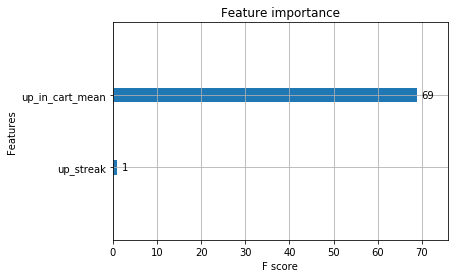

In [148]:
xgb.plot_importance(xg_cl_opt)

In [149]:
print(xg_cl_opt.feature_importances_)

[0.         0.         0.04609768 0.95390236 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
